# Exploratory Data Analysis: Cochrane Reviews & References

**Objective:** Understand the structure and quality of the downloaded data before building the LLM screening pipeline.

Key questions:
1. How many Cochrane reviews do we have? What's the year distribution?
2. Are there missing abstracts or titles?
3. How many references per review? How many have resolvable PMIDs?
4. Can we identify "included" vs "excluded" papers from the reference graph?

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Paths
DATA_DIR = Path.cwd().parent / "Data" if not (Path.cwd() / "Data").exists() else Path.cwd() / "Data"
ABSTRACTS_CSV = DATA_DIR / "cochrane_pubmed_abstracts.csv"
REFERENCES_CSV = DATA_DIR / "cochrane_pubmed_references.csv"

print(f"Data directory: {DATA_DIR}")

Data directory: c:\Users\juanx\Documents\LSE-UKHSA Project\Data


## 1. Load and Inspect Abstracts

In [2]:
# Load abstracts
abstracts = pd.read_csv(ABSTRACTS_CSV, dtype={"pmid": str, "year": str})
print(f"Total Cochrane reviews: {len(abstracts):,}")
abstracts.head()

Total Cochrane reviews: 17,092


,pmid,title,abstract,journal,year,authors
0,41527994,Surgical interventions for treating vesicovagi...,This is a protocol for a Cochrane Review (inte...,The Cochrane database of systematic reviews,2026,Okada Y; Matsushita T; Hasegawa T; Noma H; Ota...
1,41524153,Physiology- versus angiography-guided percutan...,This is a protocol for a Cochrane Review (inte...,The Cochrane database of systematic reviews,2026,Higuchi S; Yamaji N; Noma H; Ito M; Yokota Y; ...
2,41510790,Cladribine for people with multiple sclerosis.,RATIONALE: Multiple sclerosis (MS) is a chroni...,The Cochrane database of systematic reviews,2026,Celani MG; Orso M; Melis M; Ercolani MV; Canti...
3,41510785,Oral iron supplements for children in malaria-...,RATIONALE: Iron deficiency anaemia is a common...,The Cochrane database of systematic reviews,2026,Itzkovich M; Neuberger A; Harris I; Yahav D; P...
4,41500513,Exercise for depression.,RATIONALE: Depression is a common cause of mor...,The Cochrane database of systematic reviews,2026,Clegg AJ; Hill JE; Mullin DS; Harris C; Smith ...


In [3]:
# Basic info and missing values
print("Column types:")
print(abstracts.dtypes)
print("\nMissing values:")
print(abstracts.isnull().sum())
print("\nEmpty strings (non-null but blank):")
print((abstracts == "").sum())

Column types:
pmid        object
title       object
abstract    object
journal     object
year        object
authors     object
dtype: object

Missing values:
pmid         0
title        0
abstract     0
journal      0
year         0
authors     33
dtype: int64

Empty strings (non-null but blank):
pmid        0
title       0
abstract    0
journal     0
year        0
authors     0
dtype: int64


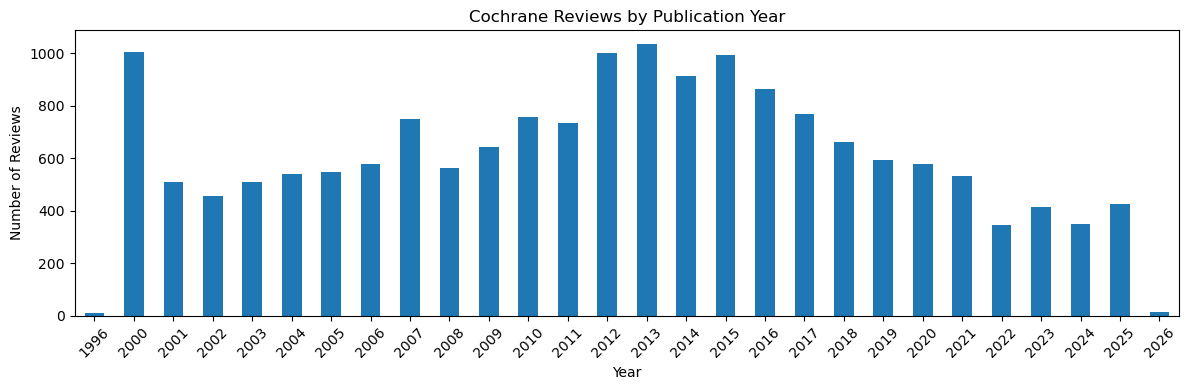

In [4]:
# Year distribution
abstracts["year_clean"] = pd.to_numeric(abstracts["year"].str[:4], errors="coerce")

fig, ax = plt.subplots(figsize=(12, 4))
abstracts["year_clean"].dropna().astype(int).value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Reviews")
ax.set_title("Cochrane Reviews by Publication Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Abstract word count statistics:
count    17092.000000
mean       545.138603
std        234.481107
min         18.000000
25%        387.000000
50%        478.000000
75%        706.000000
max       4774.000000
Name: abstract_words, dtype: float64


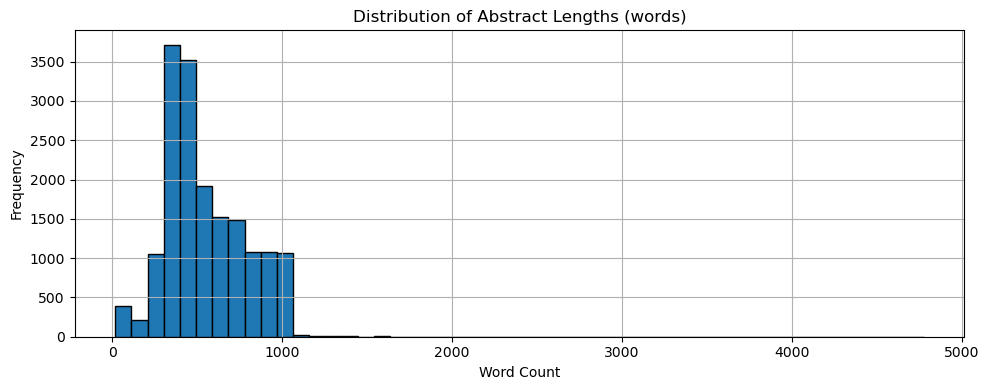

In [5]:
# Abstract length distribution
abstracts["abstract_len"] = abstracts["abstract"].fillna("").str.len()
abstracts["abstract_words"] = abstracts["abstract"].fillna("").str.split().str.len()

print("Abstract word count statistics:")
print(abstracts["abstract_words"].describe())

fig, ax = plt.subplots(figsize=(10, 4))
abstracts["abstract_words"].hist(bins=50, ax=ax, edgecolor="black")
ax.set_xlabel("Word Count")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Abstract Lengths (words)")
plt.tight_layout()
plt.show()

## 2. Load and Inspect References

In [6]:
# Load references
refs = pd.read_csv(REFERENCES_CSV, dtype={"citing_pmid": str, "ref_pmid": str})
print(f"Total reference edges: {len(refs):,}")
refs.head()

Total reference edges: 1,182,678


,citing_pmid,ref_pmid,ref_doi,ref_title
0,41527994,NaN,NaN,"Hillary CJ, Osman NI, Hilton P, Chapple CR. Th..."
1,41527994,NaN,NaN,"Hilton P, Ward A. Epidemiological and surgical..."
2,41527994,NaN,NaN,"Ahmed S, Genadry R, Asiamah B, Liang M, Tripat..."
3,41527994,NaN,NaN,World Health Organization (WHO). International...
4,41527994,NaN,NaN,"Adler AJ, Ronsmans C, Calvert C, Filippi V. Es..."


In [7]:
# How many unique Cochrane reviews have references?
reviews_with_refs = refs["citing_pmid"].nunique()
print(f"Cochrane reviews with at least one reference: {reviews_with_refs:,}")
print(f"Reviews without references: {len(abstracts) - reviews_with_refs:,}")

Cochrane reviews with at least one reference: 10,105
Reviews without references: 6,987


References per Cochrane review:
count    10105.000000
mean       117.038892
std        112.297287
min          2.000000
25%         54.000000
50%         84.000000
75%        139.000000
max       1890.000000
dtype: float64


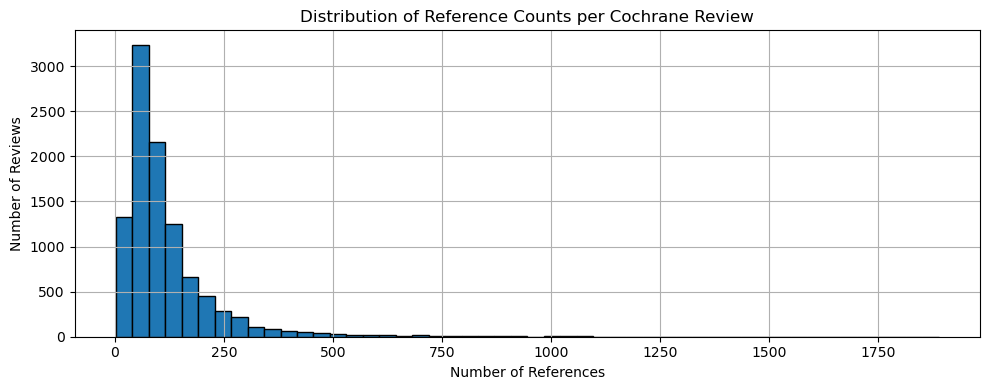

In [8]:
# References per review
refs_per_review = refs.groupby("citing_pmid").size()

print("References per Cochrane review:")
print(refs_per_review.describe())

fig, ax = plt.subplots(figsize=(10, 4))
refs_per_review.hist(bins=50, ax=ax, edgecolor="black")
ax.set_xlabel("Number of References")
ax.set_ylabel("Number of Reviews")
ax.set_title("Distribution of Reference Counts per Cochrane Review")
plt.tight_layout()
plt.show()

In [9]:
# How many references have resolvable PMIDs?
has_pmid = refs["ref_pmid"].notna() & (refs["ref_pmid"] != "")
has_doi = refs["ref_doi"].notna() & (refs["ref_doi"] != "")

print(f"References with PMID: {has_pmid.sum():,} ({100*has_pmid.mean():.1f}%)")
print(f"References with DOI:  {has_doi.sum():,} ({100*has_doi.mean():.1f}%)")
print(f"References with either: {(has_pmid | has_doi).sum():,} ({100*(has_pmid | has_doi).mean():.1f}%)")
print(f"References with neither (title only): {(~has_pmid & ~has_doi).sum():,}")

References with PMID: 848,607 (71.8%)
References with DOI:  141,573 (12.0%)
References with either: 865,992 (73.2%)
References with neither (title only): 316,686


In [10]:
# Unique referenced papers with PMIDs
unique_ref_pmids = refs.loc[has_pmid, "ref_pmid"].nunique()
print(f"Unique referenced papers with PMIDs: {unique_ref_pmids:,}")
print("These are the papers we can potentially fetch abstracts for and use in our screening task.")

Unique referenced papers with PMIDs: 491,531
These are the papers we can potentially fetch abstracts for and use in our screening task.


## 3. Key Insight: Building Ground Truth

The references in a Cochrane review represent **included** studies — papers that passed the screening criteria.

To build a ground-truth dataset for LLM evaluation, we need:
1. **Positive examples (included):** Papers that appear in the reference list of a review
2. **Negative examples (excluded):** Papers that could have been considered but were NOT included

The challenge: We don't have explicit "excluded" papers from Cochrane. Possible strategies:
- Use papers from the same topic/search that weren't included
- Sample random health papers as negatives
- Use papers referenced by related reviews but not by a specific one

In [11]:
# Sample: Pick a few reviews to examine their reference patterns
top_reviews = refs_per_review.nlargest(10)
print("Top 10 Cochrane reviews by reference count:")
for pmid, count in top_reviews.items():
    title = abstracts.loc[abstracts["pmid"] == pmid, "title"].values
    title_str = title[0][:80] + "..." if len(title) > 0 and len(title[0]) > 80 else (title[0] if len(title) > 0 else "N/A")
    print(f"  PMID {pmid}: {count} refs — {title_str}")

Top 10 Cochrane reviews by reference count:
  PMID 29543326: 1890 refs — Non-invasive diagnostic tests for Helicobacter pylori infection.
  PMID 33075160: 1788 refs — Drugs for preventing postoperative nausea and vomiting in adults after general a...
  PMID 21678355: 1231 refs — Antipsychotic medication for early episode schizophrenia.
  PMID 37436070: 1156 refs — Systemic pharmacological treatments for chronic plaque psoriasis: a network meta...
  PMID 22419320: 1151 refs — Antioxidant supplements for prevention of mortality in healthy participants and ...
  PMID 36971690: 1087 refs — Methylphenidate for children and adolescents with attention deficit hyperactivit...
  PMID 41342306: 1087 refs — Methylphenidate for children and adolescents with attention deficit hyperactivit...
  PMID 35603936: 1085 refs — Systemic pharmacological treatments for chronic plaque psoriasis: a network meta...
  PMID 39625083: 1056 refs — Exercise for osteoarthritis of the knee.
  PMID 38032037: 1033 refs 

## 4. Summary & Next Steps

### Data Summary
- **Cochrane reviews:** ~17K with abstracts
- **Reference edges:** ~1.2M
- **Unique referenced papers with PMIDs:** (see above)

### Next Steps
1. **Fetch abstracts for referenced papers** — We need the text of included papers
2. **Design negative sampling strategy** — How to get "excluded" examples
3. **Extract inclusion/exclusion criteria** from Cochrane abstract text (often in METHODS section)
4. **Build annotated validation set** — Sample ~500-1000 (paper, review, label) tuples